In [45]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from holodecml.data import load_raw_datasets, load_train_patches, load_unet_datasets_xy
from holodecml.losses import unet_loss_xy


In [46]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "medium"
output_cols = ["x", "y", "z", "d", "hid"]
subset = False
scaler_out = MinMaxScaler()
rad = 32

In [47]:
train_inputs,\
train_outputs,\
valid_inputs,\
valid_outputs = load_unet_datasets_xy(path_data,
                                     num_particles,
                                     ["x", "y", "hid"],
                                     False,
                                     10)

In [48]:
train_inputs_raw,\
train_outputs_raw = load_raw_datasets(path_data, num_particles,
                                      'train', output_cols, subset)

valid_inputs_raw,\
valid_outputs_raw = load_raw_datasets(path_data, num_particles,
                                      'valid', output_cols, subset)


In [49]:
def plot_hologram_xy(h, inputs, outputs, path):
    """
    Given a hologram number, plot hologram and particle point
    
    Args: 
        h: (int) hologram index
        inputs: (pd df) input images
        outputs: (pd df) output x and y values by hid
    
    Returns:
        print of pseudocolor plot of hologram and hologram particles
    """    
    x_vals = np.linspace(-888, 888, inputs[h, :, :].shape[0])
    y_vals = np.linspace(-592, 592, inputs[h, :, :].shape[1])

    plt.figure(figsize=(12, 8), facecolor='white')
    plt.pcolormesh(x_vals, y_vals, inputs[h, :, :].T, cmap="RdBu_r")
    h_particles = np.where(outputs["hid"] == h + 1)[0]
    for h_particle in h_particles:
        plt.scatter(outputs.loc[h_particle, "x"],
                    outputs.loc[h_particle, "y"],
                    c="b", s=100)
    plt.xticks([])
    plt.yticks([])
#     plt.xlabel("horizontal particle position (µm)", fontsize=16)
#     plt.ylabel("vertical particle position (µm)", fontsize=16)
    plt.title(f"Hologram {h} contains {h_particles.shape[0]} particles", fontsize=20, pad=20)
    plt.savefig(path + "input_hologram.png", facecolor=fig.get_facecolor(), dpi=200, bbox_inches="tight")
    

/glade/u/home/ggantos/miniconda3/envs/micro/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


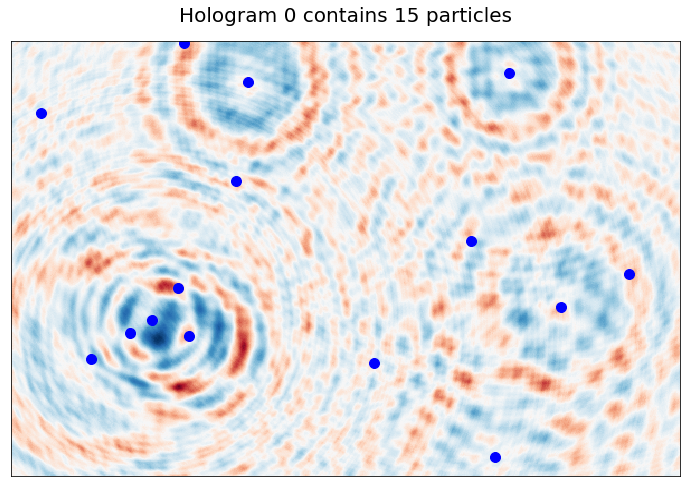

In [40]:
plot_hologram_xy(0, valid_inputs_raw, valid_outputs_raw, path_preds)


In [50]:
path_preds = "/glade/p/cisl/aiml/ggantos/holodec/unet/j_10_fulldata/"
valid_outputs_pred = xr.open_dataset(path_preds + "valid_outputs_pred.nc")
valid_outputs_pred = valid_outputs_pred.to_array().values[0]


In [51]:
h = 0

image_pred = valid_outputs_pred[h, :, :, 0]
image_true = valid_outputs[h, :, :, 0]


In [52]:
coords_true = np.where(image_true > 0)

idx = np.argwhere(np.diff(np.sort(image_pred.flatten())) > .0001)+1
pred_argsort = image_pred.flatten().argsort()
coords_pred = []
for i in pred_argsort[-idx.shape[0]:][::-1]:
    coord = np.array([c[0] for c in np.where(image_pred == image_pred.flatten()[i])])
    coords_pred.append(coord)
coords_pred = np.stack(coords_pred)

In [53]:
coords_pred.shape

(43, 2)

/glade/u/home/ggantos/miniconda3/envs/micro/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


14.2374325
0.0
0.99980646


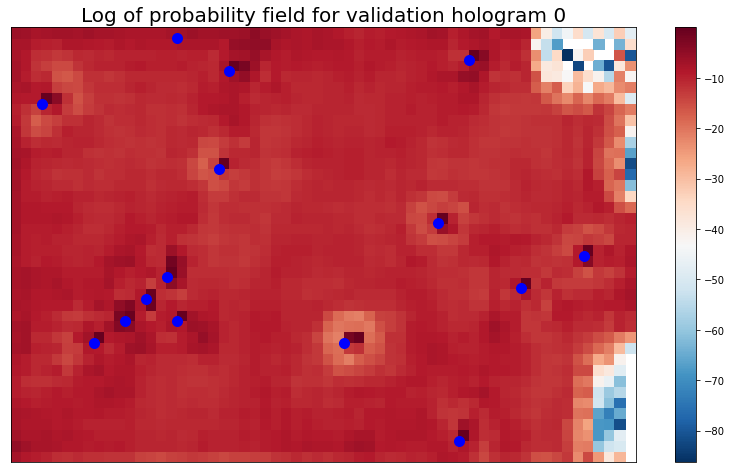

In [31]:
fig=plt.figure(figsize=(14, 8), facecolor='white')
plt.pcolormesh(np.log(image_pred).T, cmap="RdBu_r")
plt.colorbar()
plt.scatter(np.where(image_true > 0)[0], np.where(image_true > 0)[1], color='blue', s=100, label="True")
print(np.sum(image_pred))
print(np.min(image_pred))
print(np.max(image_pred))
plt.title(f'Log of probability field for validation hologram {h}', fontsize=20)
# plt.legend(fontsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig(path_preds + "prob_field_log.png", facecolor=fig.get_facecolor(), dpi=200, bbox_inches="tight")


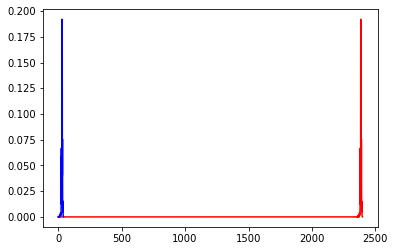

In [17]:
plt.plot(np.diff(np.sort(image_pred.flatten())), color='red')
plt.plot(np.diff(np.sort(image_pred.flatten()))[np.diff(np.sort(image_pred.flatten())) > .0001], color='blue')

/glade/u/home/ggantos/miniconda3/envs/micro/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


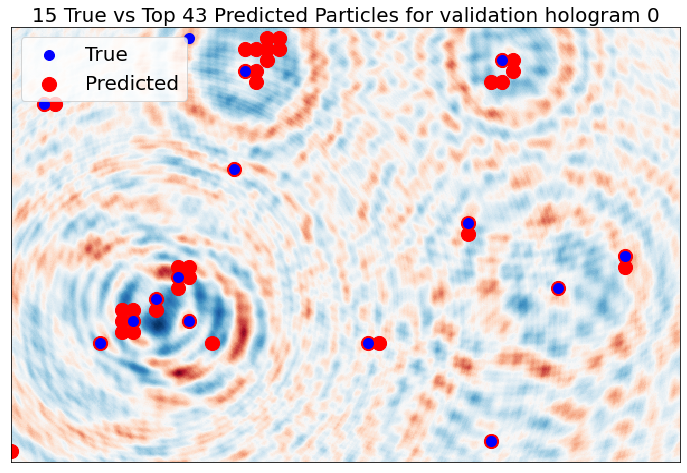

In [58]:
plt.figure(figsize=(12, 8), facecolor='white')
x_vals = np.linspace(0, 60, valid_inputs[h, :, :].shape[0])
y_vals = np.linspace(0, 40, valid_inputs[h, :, :].shape[1])
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x_vals, y_vals, valid_inputs[h, :, :].T, cmap="RdBu_r")
plt.scatter(np.where(image_true > 0)[0], np.where(image_true > 0)[1], color='blue', s=100, label="True", zorder=2)
plt.scatter(coords_pred[:, 0], coords_pred[:, 1], color='red', s=200, label="Predicted", zorder=1)
plt.legend(fontsize=20)
plt.title(f'{int(np.sum(image_true))} True vs Top {idx.shape[0]} Predicted Particles for validation hologram {h}', fontsize=20)
plt.savefig(path_preds + "true_vs_pred_diff.png", facecolor=fig.get_facecolor(), dpi=200, bbox_inches="tight")

In [20]:
pred_argsort = image_pred.flatten().argsort()
coords_pred = []
for i in pred_argsort[-int(np.sum(image_true)):][::-1]:
    coord = np.array([c[0] for c in np.where(image_pred == image_pred.flatten()[i])])
    coords_pred.append(coord)
coords_pred = np.stack(coords_pred)


In [57]:
coords_pred[:pars_true, 0].shape

(15,)

/glade/u/home/ggantos/miniconda3/envs/micro/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


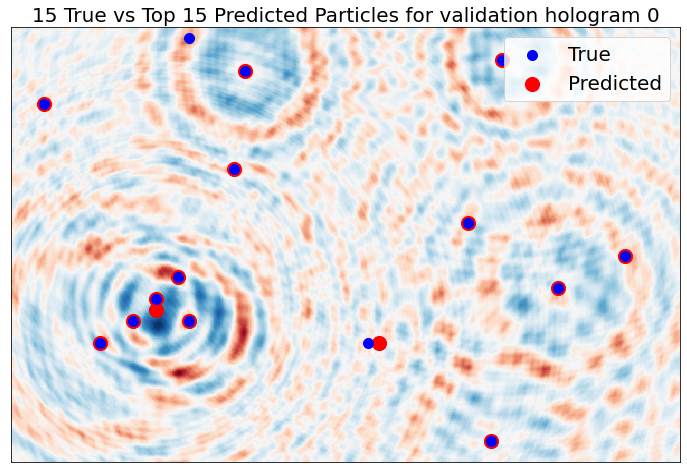

In [56]:
plt.figure(figsize=(12, 8), facecolor='white')
x_vals = np.linspace(0, 60, valid_inputs[h, :, :].shape[0])
y_vals = np.linspace(0, 40, valid_inputs[h, :, :].shape[1])
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x_vals, y_vals, valid_inputs[h, :, :].T, cmap="RdBu_r")
pars_true = int(np.sum(image_true))
plt.scatter(np.where(image_true > 0)[0], np.where(image_true > 0)[1], color='blue', s=100, label="True", zorder=2)
plt.scatter(coords_pred[:pars_true, 0], coords_pred[:pars_true, 1], color='red', s=200, label="Predicted", zorder=1)
plt.legend(fontsize=20)
plt.title(f'{int(np.sum(image_true))} True vs Top {int(np.sum(image_true))} Predicted Particles for validation hologram {h}', fontsize=20)
plt.savefig(path_preds + "true_vs_pred_toptrue.png", facecolor=fig.get_facecolor(), dpi=200, bbox_inches="tight")


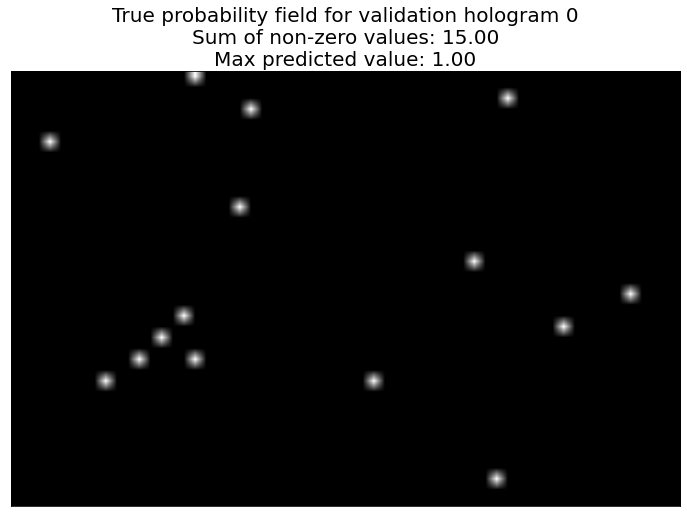

In [43]:
fig=plt.figure(figsize=(12, 8), facecolor='white')
plt.imshow(np.flipud(valid_outputs[h, :, :, 0].T), interpolation='bilinear', cmap=plt.cm.gray, aspect='auto', vmin=0, vmax=1)
plt.title(f'True probability field for validation hologram {h}\nSum of non-zero values: {np.sum(valid_outputs[h, :, :, 0]):.2f}\nMax predicted value: {np.max(valid_outputs[h, :, :, 0]):.2f}', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig(path_preds + "prob_true.png", facecolor=fig.get_facecolor(), dpi=200, bbox_inches="tight")


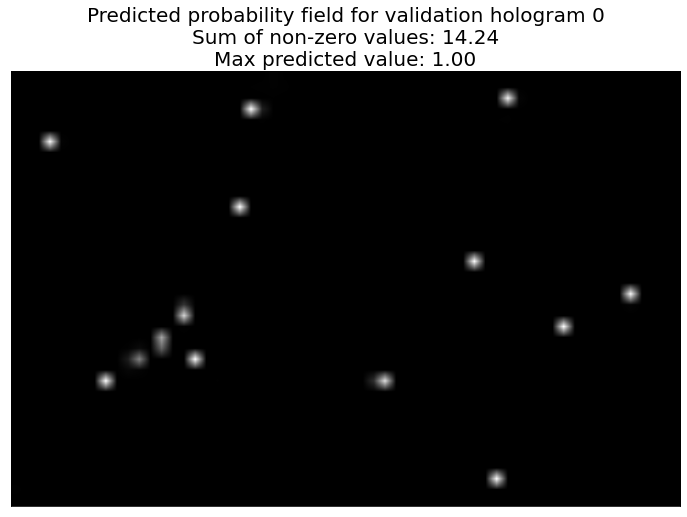

In [44]:
fig=plt.figure(figsize=(12, 8), facecolor='white')
plt.imshow(np.flipud(image_pred.T), interpolation='bilinear', cmap=plt.cm.gray, aspect='auto', vmin=0, vmax=1)
plt.title(f'Predicted probability field for validation hologram {h}\nSum of non-zero values: {np.sum(image_pred):.2f}\nMax predicted value: {np.max(image_pred):.2f}', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig(path_preds + "prob_pred.png", facecolor=fig.get_facecolor(), dpi=200, bbox_inches="tight")
